<a href="https://colab.research.google.com/github/hardiksharma2005/Time-series-forcasting/blob/main/Time_Series_Forcasting_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Day 1



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
# Step 1 Loading data
ticker = 'GOOGL'
df = yf.download(ticker, start='2019-01-01', end='2024-01-01')

# Keeping only the 'Close' column for simplicity
data = df[['Close']].copy()

/tmp/ipython-input-1985715859.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2019-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed


In [3]:
# Step 2 Data preprocessing
print(data.index.dtype)
if data.isnull().sum().sum() > 0:
    data.fillna(method='ffill', inplace=True)

datetime64[ns]


In [4]:
# Step 3 EDA & visualization
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,97.456651,98.507876,96.345809,97.392339,3.365043e+07
std,29.469625,29.782025,29.182392,29.501133,1.498762e+07
min,50.888996,52.106300,50.065226,50.974846,9.312000e+06
25%,69.257950,70.092399,68.272277,69.219990,2.427300e+07
50%,99.220322,100.341844,97.433818,98.783620,2.991775e+07
75%,123.705307,124.966918,122.226364,123.814492,3.780450e+07
max,148.714859,150.410035,147.782387,150.115765,1.331780e+08


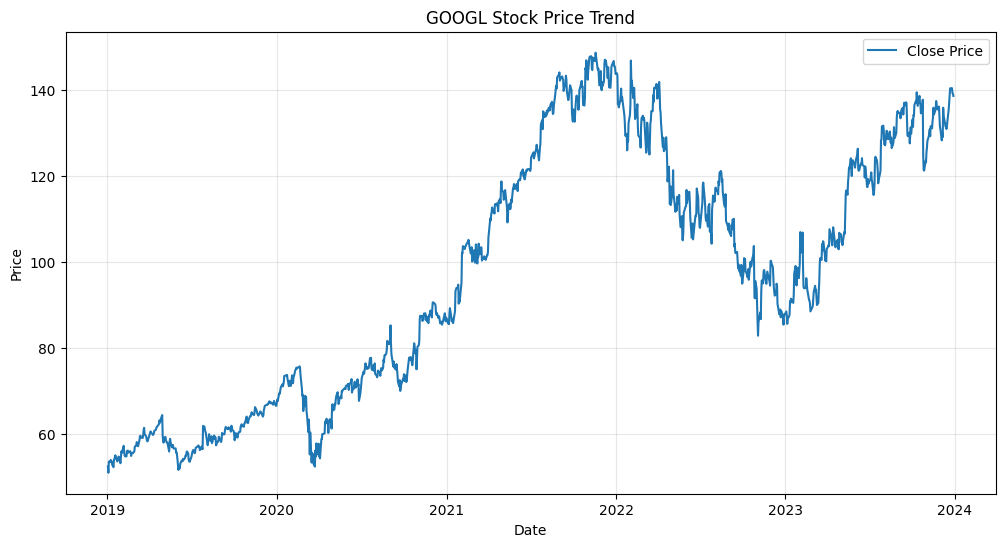

In [5]:
# Visualization of the trend
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='#1f77b4')

plt.title(f"{ticker} Stock Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

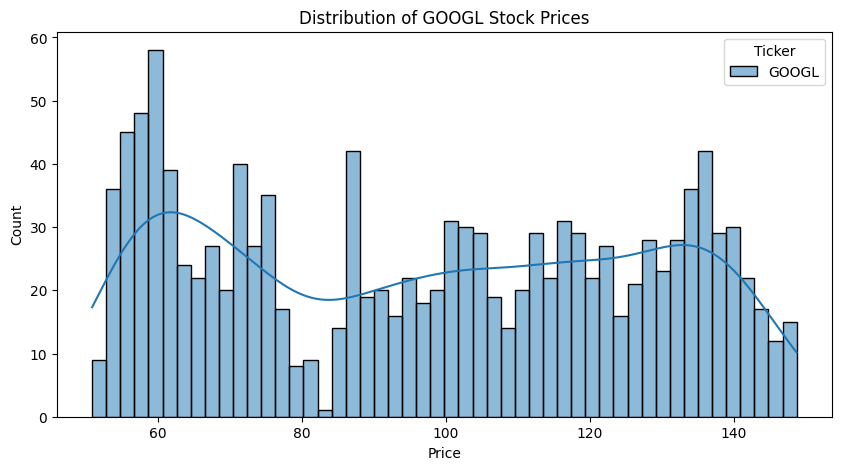

In [6]:
# Distribution of prices
plt.figure(figsize=(10, 5))
sns.histplot(data['Close'], kde=True, color='purple', bins=50)
plt.title(f"Distribution of {ticker} Stock Prices")
plt.xlabel("Price")
plt.show()

Day 2

In [7]:
# calculating moving averages
# Shows short-term sentiment.
data['MA_50'] = data['Close'].rolling(window=50).mean()

# Shows the major long-term trend.
data['MA_200'] = data['Close'].rolling(window=200).mean()

In [8]:
# calculating volatility
data['Volatility'] = data['Close'].rolling(window=20).std()

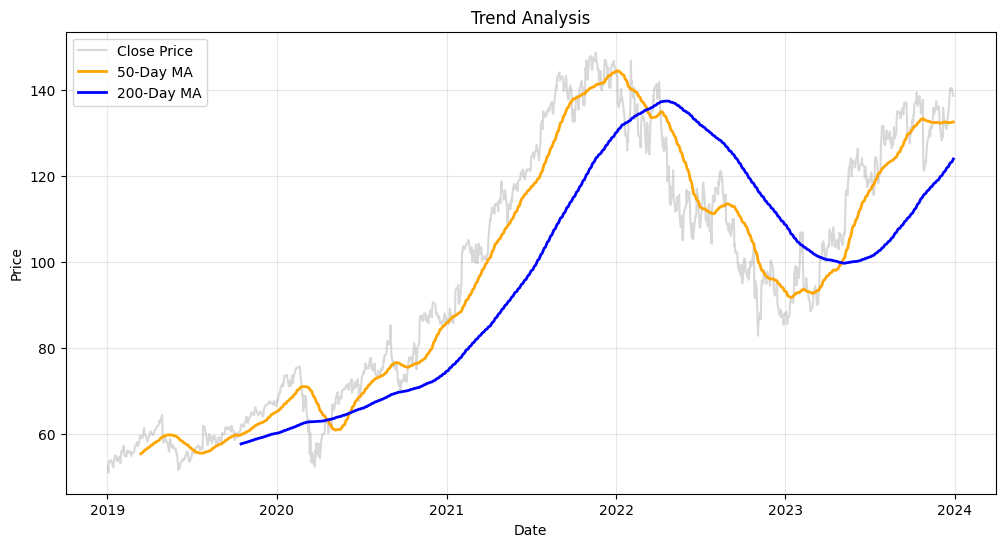

In [9]:
plt.figure(figsize=(12, 6))

plt.plot(data.index, data['Close'], label='Close Price', alpha=0.3, color='gray')

# Plotting moving averages
plt.plot(data.index, data['MA_50'], label='50-Day MA', color='orange', linewidth=2)
plt.plot(data.index, data['MA_200'], label='200-Day MA', color='blue', linewidth=2)

plt.title("Trend Analysis")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

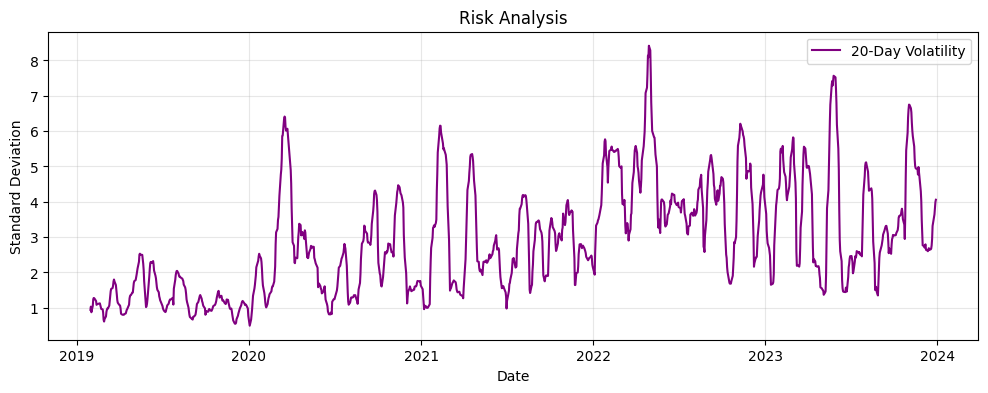

In [10]:
# Plotting the risk
plt.figure(figsize=(12, 4))

plt.plot(data.index, data['Volatility'], label='20-Day Volatility', color='purple')

plt.title("Risk Analysis")
plt.xlabel("Date")
plt.ylabel("Standard Deviation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()